# Code for Final

## Load Libraries

In [1]:
import os; import numpy as np; import pandas as pd; import re; import statistics;
import datetime; import matplotlib.pyplot as plt; import statsmodels.formula.api as smf;
from scipy import stats; import matplotlib; import matplotlib.pyplot as plt; import seaborn as sns;
from stargazer.stargazer import Stargazer;
os.getcwd()

'c:\\Users\\galen\\Documents\\GitHub_Repos\\JHU\\AS_470_708\\Final'

## Load Data Sets

In [2]:
#Bring in data by cohort/major https://collegescorecard.ed.gov/data/ (contains Field of Study Level)
Cohort_data = pd.read_csv('Most-Recent-Cohorts-Field-of-Study.csv')

#Bring in USNews_data #Copied to Excel https://premium.usnews.com/best-colleges/rankings/national-universities 
USNews_data = pd.read_excel('USNewsData.xlsx')

#Bring in all Scorecard Data (big dataset) https://collegescorecard.ed.gov/data/ Institution Level
All_fields_data = pd.read_csv('Most-Recent-Cohorts-All-Data-Elements.csv', low_memory=False)

#CIP Codes from https://nces.ed.gov/ipeds/cipcode/resources.aspx?y=55
cip_codes_legend = pd.read_csv('CIPCode2010.csv')

## Begin Cleaning and formatting from Raw Data Sets
Some preprocessing was conducted such as obtaining the UNITID and OPEID6 where I first joined the name of the University with the cohort data, and manually searched up the remaning which were due to slightly different naming conventions.

Cleaning the USNewsData

In [3]:
#obtain number only, with no (fall 2020) and no comma
USNews_data['UG_Enroll'] = USNews_data['Undergraduate Enrollment'].str[:-13].replace(",", "", regex=True)

#remove # from rank and change it to numeric
USNews_data['Rank_Int'] = USNews_data['Rank'].str[1:].astype('float64')

#obtain universities are rank 100 or better
USNews_data_TopHundred = USNews_data.query('Rank_Int <= 100').copy()

Subsetting the Most Recent Cohorts Field of Study Data so that it only contains values from the top 100 Schools

In [4]:
#Set the Merge column to the same data type as the USNews Merge Column (Int64)
Cohort_data['UNITID'] = Cohort_data['UNITID'].astype("float64")

#Remove NA values from the merge column (All schools in Top 100 have a UNITID, unable to join if column has NA's)
Cohort_data_NoNA = Cohort_data[Cohort_data['UNITID'].notna()].copy()

#Inner Join the USNewsRankings to the CohortInfo
Cohort_and_Top100 = Cohort_data_NoNA.merge(USNews_data_TopHundred, on = 'UNITID', how = 'inner')

#Select out only Bachelor level graduates
Cohort_and_Top100 = Cohort_and_Top100[Cohort_and_Top100["CREDDESC"] == "Bachelors Degree"]

Subsetting the Most Recent Cohorts All Data Elements Data

In [5]:
#This now has all three data sources combined
All_data_combined =  All_fields_data.merge(Cohort_and_Top100, on = 'UNITID', how = 'inner')

##NEW## Using averages of cohort data to describe institution rather than using seprate variables
desired_columns = ['Rank_Int', 'INSTNM_x','UNITID','OPEID6_y','LATITUDE','LONGITUDE',
                    'HBCU','ADM_RATE','SAT_AVG','UGDS','UGDS_WHITE','UGDS_BLACK',
                    'UGDS_HISP','UGDS_ASIAN','TUITFTE','INEXPFTE','AVGFACSAL','PFTFAC',
                    'PCTPELL', 'SCHTYPE','OMAWDP8_FULLTIME','CIPCODE','CIPDESC',
                    'EARN_MDN_HI_1YR']

#Create a subset dataframe
data_subset = All_data_combined[desired_columns].copy()

#Rename certain columns so there is no suffix
data_subset.rename(columns = {'INSTNM_x':'NAME',
                    'OPEID6_y': 'OPEID6',
                    'Rank_Int': 'RANKING'}, inplace = True)
                    
#Sort the values first by Ranking, then by College ID, then by CIPCODE (Majors)
data_subset = data_subset.sort_values(by=['RANKING', 'UNITID', 'CIPCODE']).copy()

Data with Major Controls Data Set

In [11]:
#Create a copy of the data for manipulation
data_w_majors = data_subset.copy()
#print(data_subset_with_major_controls.dtypes)

#Make CIPCODE into a string
data_w_majors['CIPCODE'] = data_w_majors['CIPCODE'].astype('string')

#Sting split the CIPCODE to "Family" categories (disregard the right two digits)
data_w_majors['CIPFamily'] = data_w_majors['CIPCODE'].str[:-2]

#Make a copy of the CIP Legend for aggregating majors together (Classification of Instructional Programs)
cip_codes_legend_cleaned = cip_codes_legend.copy()

#First strip the digits from the CIP Family, otherwise will have the ="" surrounding the numbers, then cast as int to remove leading 0, then cast back to string for joining.
cip_codes_legend_cleaned['CIPFamily'] = cip_codes_legend_cleaned['CIPFamily'].str.replace('\D', '', regex=True).astype('int64').astype('string')
cip_codes_legend_cleaned = cip_codes_legend_cleaned.drop_duplicates(subset = 'CIPFamily', keep = 'first').copy()
cip_codes_legend_cleaned_subset = cip_codes_legend_cleaned[['CIPFamily', 'CIPTitle', 'CIPDefinition']]

#Join the CIP Family information with the rest of the data
data_w_majors_and_cip = data_w_majors.merge(cip_codes_legend_cleaned_subset, on = 'CIPFamily', how = 'left')

#Replace Privacy Surpressed with np.NaN
data_w_majors_and_cip['EARN_MDN_HI_1YR'] = data_w_majors_and_cip['EARN_MDN_HI_1YR'].replace('PrivacySuppressed', np.NaN)
# #Cast CIP Family back to float64 for regression now that it is joined
data_w_majors_and_cip['CIPFamily'] = data_w_majors_and_cip['CIPFamily'].astype('float64')

#After making privacy surpressed into np.NAN, now we cast to float for describe (1 YR)
data_w_majors_and_cip['EARN_MDN_HI_1YR'] = data_w_majors_and_cip['EARN_MDN_HI_1YR'].astype('float64')
#data_w_majors_and_cip[data_w_majors_and_cip['EARN_MDN_HI_1YR'].notna()] #for counts of total programs (4113)

# #Number of Observations
data_w_majors_and_cip[data_w_majors_and_cip['EARN_MDN_HI_1YR'].notna()].groupby(["NAME", "CIPTitle"]).agg("mean");

# #Range of programs per institution
#data_w_majors_and_cip[data_w_majors_and_cip['EARN_MDN_HI_1YR'].notna()].groupby(["NAME", "CIPTitle"]).agg("mean").groupby("NAME").agg("count").mean()
#data_w_majors_and_cip[data_w_majors_and_cip['EARN_MDN_HI_1YR'].notna()].groupby(["NAME", "CIPTitle"]).agg("mean").groupby("NAME").agg("count").median()
#data_w_majors_and_cip[data_w_majors_and_cip['EARN_MDN_HI_1YR'].notna()].groupby(["NAME", "CIPTitle"]).agg("mean").groupby("NAME").agg("count").max()
#data_w_majors_and_cip[data_w_majors_and_cip['EARN_MDN_HI_1YR'].notna()].groupby(["NAME", "CIPTitle"]).agg("mean").groupby("NAME").agg("count").min()


## Data Prep

### Visual of Income to Rank sorted all 100

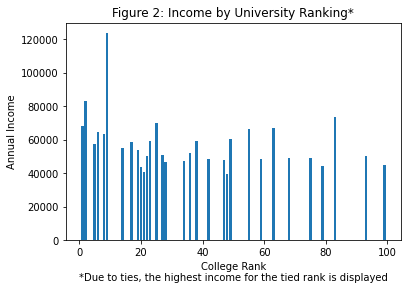

In [14]:
#Get the meaninful columns
data_w_majors_and_cip = data_w_majors_and_cip[['RANKING', 'NAME', 'ADM_RATE', 'UGDS','UGDS_WHITE', 
                                                'UGDS_BLACK', 'UGDS_HISP', 'UGDS_ASIAN',
                                                'TUITFTE', 'INEXPFTE', 'AVGFACSAL', 'PCTPELL',
                                                'EARN_MDN_HI_1YR', "SAT_AVG", 'CIPFamily',
                                                'CIPTitle', 'CIPDefinition']]

#Get summary stats for graph
income_no_major = data_w_majors_and_cip[data_w_majors_and_cip['EARN_MDN_HI_1YR'].notna()].groupby(by = ["NAME"]).agg("mean").reset_index()
#Sort the values
income_rank_graph_data = income_no_major.sort_values("RANKING")

#Create graph of Rank and Income
plt.bar(income_rank_graph_data["RANKING"], income_rank_graph_data["EARN_MDN_HI_1YR"])
plt.title('Figure 2: Income by University Ranking*')
plt.xlabel('College Rank\n*Due to ties, the highest income for the tied rank is displayed')
plt.ylabel('Annual Income')
plt.show()

#Get a Table of the Program of Study and the Income
majors_descrpitive = data_w_majors_and_cip[data_w_majors_and_cip['EARN_MDN_HI_1YR'].notna()].groupby(["CIPTitle"]).agg("mean").reset_index()
majors_descrpitive["Income"] = majors_descrpitive["EARN_MDN_HI_1YR"].apply(lambda x : f"${x:,.2f}")
majors_descrpitive = majors_descrpitive[["CIPTitle", "Income"]]
majors_descrpitive = majors_descrpitive.rename({"CIPTitle":"Program of Study"}, axis = 1)
majors_descrpitive; #Remove semicolon for income by program of study

## Data Analysis -- Hypothesis Testing

In [15]:
#### Subsetting the rankings in two for hypothesis testing
#Get the Top 50 Schools
top50 = income_no_major[income_no_major["RANKING"] <= 50]
#Get the other 50 Schools
bot50 = income_no_major[income_no_major["RANKING"] > 50]

Hypothesis Testing 1 to 50 vs 51 to 100

In [16]:
#Test using mean of the medians of the aggregate of the majors for university wide stats
mn_one_yr_ttest = stats.ttest_ind(top50["EARN_MDN_HI_1YR"], bot50["EARN_MDN_HI_1YR"], alternative = 'greater', equal_var = False)

print("The one-sided t-test comparing the mean of the mean of the medians of the incomes by major for the university one year after college graduation is:\n", mn_one_yr_ttest)

#For visual
mean_top_50 = statistics.mean(top50["EARN_MDN_HI_1YR"])
mean_bot_50 = statistics.mean(bot50["EARN_MDN_HI_1YR"])

The one-sided t-test comparing the mean of the mean of the medians of the incomes by major for the university one year after college graduation is:
 Ttest_indResult(statistic=2.8236618668629068, pvalue=0.0029404114303227496)


Redoing but 1 to 20 and 21 to 40

In [17]:
#### Subsetting the rankings in two for hypothesis testing
#Get the Top 20 Schools
top_40 = income_no_major[income_no_major["RANKING"] <= 40]

top20 = top_40[top_40["RANKING"] <= 20]
#Get the other 20 Schools out of top 40
bot20 = top_40[top_40["RANKING"] > 20]

#Test using mean of the medians of the aggregate of the majors for university wide stats
mn_one_yr_ttest = stats.ttest_ind(top20["EARN_MDN_HI_1YR"], bot20["EARN_MDN_HI_1YR"], equal_var = False)
mn_one_yr_ttest_greater = stats.ttest_ind(top20["EARN_MDN_HI_1YR"], bot20["EARN_MDN_HI_1YR"], alternative="greater", equal_var = False)

print("The t-test comparing the mean of the mean of the medians of the incomes by major for the university one year after college graduation is:\n", mn_one_yr_ttest)
print("The one-sided t-test comparing the mean of the mean of the medians of the incomes by major for the university one year after college graduation is:\n", mn_one_yr_ttest_greater)

#We can see looking at both the mean of the medians and the median of the medians, there is a statistical difference in the means of the groups.
#For visual
mean_top_20 = statistics.mean(top20["EARN_MDN_HI_1YR"])
mean_bot_20 = statistics.mean(bot20["EARN_MDN_HI_1YR"])

The t-test comparing the mean of the mean of the medians of the incomes by major for the university one year after college graduation is:
 Ttest_indResult(statistic=2.9735311002171723, pvalue=0.006545496512450752)
The one-sided t-test comparing the mean of the mean of the medians of the incomes by major for the university one year after college graduation is:
 Ttest_indResult(statistic=2.9735311002171723, pvalue=0.003272748256225376)


### Visual of Hypothesis

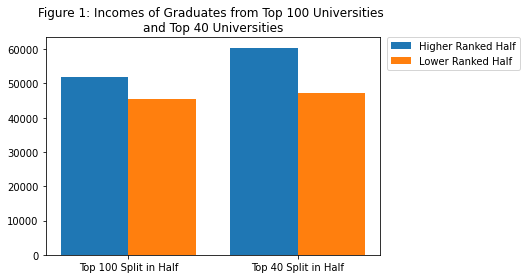

In [18]:
## Visual
group = ["Top 100 Split in Half", "Top 40 Split in Half"]
higher_ranks = [mean_top_50, mean_top_20]
lower_ranks = [mean_bot_50, mean_bot_20]
x_axis = np.arange(len(group))

# Multi bar Chart
plt.bar(x_axis -0.2, higher_ranks, width=0.4, label = 'Higher Ranked Half')
plt.bar(x_axis +0.2, lower_ranks, width=0.4, label = 'Lower Ranked Half')

# Xticks
plt.xticks(x_axis, group)

#Title
plt.title("Figure 1: Incomes of Graduates from Top 100 Universities \nand Top 40 Universities")
# Add legend
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

# Display
plt.show()

## Data Analysis -- Regression


In [19]:
#### No Controls - Using 1 Yr
reg0 = smf.ols('EARN_MDN_HI_1YR ~ RANKING', data = income_no_major).fit(cov_type='HC1')

#print(reg0.summary())

#### Expenses per Student - Using 1 Yr
reg1 = smf.ols('EARN_MDN_HI_1YR ~ RANKING + INEXPFTE', data = income_no_major).fit(cov_type='HC1')
#print(reg1.summary())

#### Faculty - Using 1 Yr
reg2 = smf.ols('EARN_MDN_HI_1YR ~ RANKING + AVGFACSAL', data = income_no_major).fit(cov_type='HC1')
#print(reg2.summary())

#### SAT Score - Using 1 Yr
reg3 = smf.ols('EARN_MDN_HI_1YR ~ RANKING + SAT_AVG', data = income_no_major).fit(cov_type='HC1')
#print(reg3.summary())

#### Major Controls - Using 1 Yr
reg4 = smf.ols('EARN_MDN_HI_1YR ~ RANKING + C(CIPTitle)', data = data_w_majors_and_cip).fit(cov_type='HC1')
#print(reg4.summary())

#### Full - Using 1 Yr
reg5 = smf.ols('EARN_MDN_HI_1YR ~ RANKING + INEXPFTE + AVGFACSAL + SAT_AVG + C(CIPTitle)', data = data_w_majors_and_cip).fit(cov_type='HC1')
#print(reg5.summary())

#### Create a Summary Table
table = Stargazer([reg0, reg1, reg2, reg3, reg4, reg5])
table.custom_columns(['Model 1-No Controls', 'Model 2-Expendeture Control', 'Model 3-Faculty Salary Control', ' Model 4-SAT Control', 'Model 5-Major Controls', 'Model 6-All Controls'], [1, 1, 1, 1, 1, 1])
table.covariate_order(["AVGFACSAL", "INEXPFTE", "RANKING", "SAT_AVG", "Intercept"])
table.rename_covariates({'AVGFACSAL': 'FACULTY SALARY', 'INEXPFTE': 'INSTRUCTIONAL EXPENDITURE', "SAT_AVG":"SAT", "Intercept": "INTERCEPT"})
table.add_line('MAJOR', ['NO', 'NO', 'NO', 'NO', 'YES', 'YES'])
table.render_html()

c:\Users\galen\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 40, but rank is 33
  warnings.warn('covariance of constraints does not have full '
c:\Users\galen\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 43, but rank is 36
  warnings.warn('covariance of constraints does not have full '


'<table style="text-align:center"><tr><td colspan="7" style="border-bottom: 1px solid black"></td></tr><tr><td style="text-align:left"></td><td colspan="6"><em>Dependent variable:EARN_MDN_HI_1YR</em></td></tr><tr><td style="text-align:left"></td><tr><td></td><td colspan="1">Model 1-No Controls</td><td colspan="1">Model 2-Expendeture Control</td><td colspan="1">Model 3-Faculty Salary Control</td><td colspan="1"> Model 4-SAT Control</td><td colspan="1">Model 5-Major Controls</td><td colspan="1">Model 6-All Controls</td></tr><tr><td style="text-align:left"></td><td>(1)</td><td>(2)</td><td>(3)</td><td>(4)</td><td>(5)</td><td>(6)</td></tr><tr><td colspan="7" style="border-bottom: 1px solid black"></td></tr><tr><td style="text-align:left">FACULTY SALARY</td><td></td><td></td><td>2.339<sup>**</sup></td><td></td><td></td><td>0.877<sup>***</sup></td></tr><tr><td style="text-align:left"></td><td></td><td></td><td>(0.939)</td><td></td><td></td><td>(0.143)</td></tr><tr><td style="text-align:left">